In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [18]:
data = pd.read_excel("test.xlsx")
data.head()

,hour,date_miladi,date_shamsi,code,unit_no,fuel_type,mvar,temp,moisture,power
0,1,2020-01-13,1398/10/23,SO,1,A,11,3,94,119
1,2,2020-01-13,1398/10/23,SO,1,A,11,3,96,119
2,3,2020-01-13,1398/10/23,SO,1,A,10,2,95,120
3,4,2020-01-13,1398/10/23,SO,1,A,11,2,95,120
4,5,2020-01-13,1398/10/23,SO,1,A,11,2,95,121


In [19]:
data=data[data["power"]>100]
data.shape

(756, 10)

In [20]:
# Change object to integer:
data["fuel_type"][data["fuel_type"]=="A"] = 1; 
data["fuel_type"][data["fuel_type"]=="B"] = 2;
data["fuel_type"][data["fuel_type"]=="C"] = 3;

In [21]:
data['fuel_type'].value_counts()

1    508
Name: fuel_type, dtype: int64

In [22]:
data["fuel_type"].fillna(method='bfill', inplace=True)

In [23]:
data.isnull().sum()

hour           0
date_miladi    0
date_shamsi    0
code           0
unit_no        0
fuel_type      0
mvar           0
temp           0
moisture       0
power          0
dtype: int64

In [24]:
X = data[["moisture","unit_no","temp","fuel_type"]]
y = data[["power"]]
y

,power
0,119
1,119
2,120
3,120
4,121
...,...
994,110
995,127
996,127
997,124


In [25]:
X

,moisture,unit_no,temp,fuel_type
0,94,1,3,1
1,96,1,3,1
2,95,1,2,1
3,95,1,2,1
4,95,1,2,1
...,...,...,...,...
994,6,6,15,1
995,8,6,16,1
996,21,6,18,1
997,11,6,19,1


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [28]:
# Define base models 
gbr_model = GradientBoostingRegressor() 
rf_model = RandomForestRegressor() 
svr_model = SVR()

In [29]:
stacked_model = StackingCVRegressor(regressors=[gbr_model, rf_model, svr_model],
                                    meta_regressor=gbr_model, cv=5, use_features_in_secondary=True)
stacked_model.fit(X_train, y_train)
y_pred=stacked_model.predict(X_test)

In [30]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 50.94796523843419
R-squared: 0.5521817093235173


# Trying dimention reduction

In [51]:
# Apply PCA to reduce the number of features to 3
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

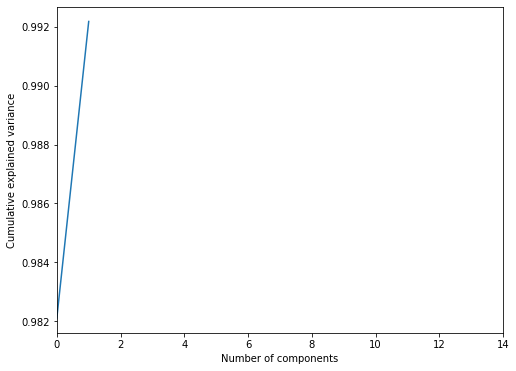

In [52]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

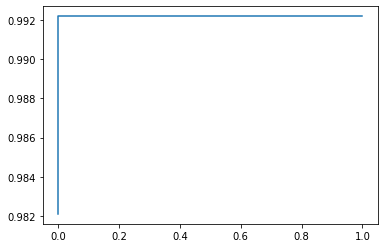

In [53]:
cumulative=np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))],cumulative)
plt.show()

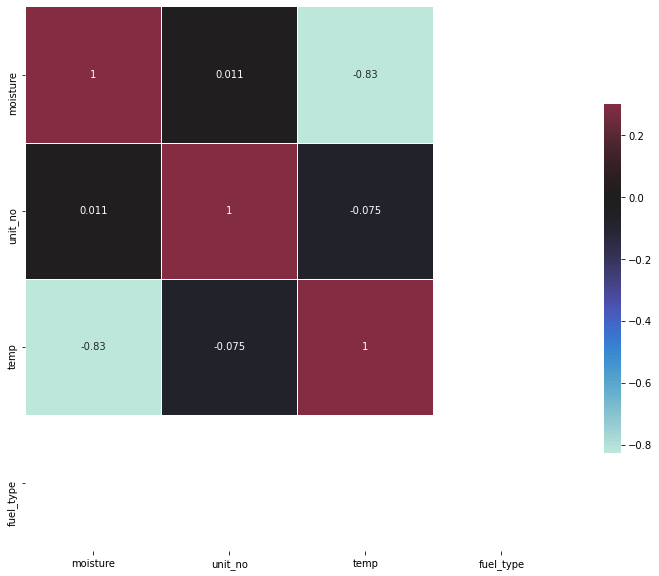

In [54]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(),vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.tight_layout()
plt.show()

In [55]:
pca=PCA().fit(X_train)
print(pca.explained_variance_ratio_)
print()
print(X_train.columns.values.tolist())

[0.98211081 0.0100714  0.00781778 0.        ]

['moisture', 'unit_no', 'temp', 'fuel_type']


In [56]:
pipeline = Pipeline([
    ('pca', PCA(n_components=2)),
    ('st', StackingCVRegressor(regressors=[gbr_model, rf_model, svr_model],
                                    meta_regressor=gbr_model, cv=5, use_features_in_secondary=True))
])

In [57]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [58]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 141.2230861096178
R-squared: -3.3481675992748645
